# Active Inference cadCAD model

This notebook explores active inference agent modeling in arbitrarily large grid worlds.

## Developing Active Inference Agents in cadCAD

An active inference agent consists of the following matrices:
- $A$ -> $P(o|s)$ the generative model's prior beliefs about how hidden states relate to observations
- $B$ -> $𝑃(𝑠_𝑡∣𝑠_{𝑡−1},𝑢_{𝑡−1})$ the generative model's prior beliefs about controllable transitions between hidden states over time
- $C$ -> $P(o)$ the biased generative model's prior preference for particular observations encoded in terms of probabilities
- $D$ -> $P(s)$ the generative model's prior belief over hidden states at the first timestep
- $E$ -> agent's affordances (in this notebook referred to as 'actions')

## cadCAD Standard Notebook Layout

### 0. Dependencies

In [14]:
!pip install inferactively-pymdp

In [26]:
import pandas as pd
import numpy as np
from random import normalvariate, random
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import sys

sys.path.insert(0, '../')

from radcad import Model, Simulation, Experiment


# Additional dependencies
from pymdp.control import construct_policies

# For analytics
import itertools

# For visualization
import plotly.express as px

# local utils
import blockference.utils.utils as utils
from blockference.gridference import ActiveGridference

### 0. Useful functions

In [27]:
grid = list(itertools.product(range(10), repeat=2))
print(grid)
act = ActiveGridference(grid)
act.get_C((2, 3))
act.get_D((0, 0))
print(act.border)
print(len(grid))

[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (6, 8), (6, 9), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7), (7, 8), (7, 9), (8, 0), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (8, 8), (8, 9), (9, 0), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8), (9, 9)]
9.0
100


In [28]:
from pymdp.maths import softmax

print(softmax(act.A))

[[0.02672363 0.00983107 0.00983107 ... 0.00983107 0.00983107 0.00983107]
 [0.00983107 0.02672363 0.00983107 ... 0.00983107 0.00983107 0.00983107]
 [0.00983107 0.00983107 0.02672363 ... 0.00983107 0.00983107 0.00983107]
 ...
 [0.00983107 0.00983107 0.00983107 ... 0.02672363 0.00983107 0.00983107]
 [0.00983107 0.00983107 0.00983107 ... 0.00983107 0.02672363 0.00983107]
 [0.00983107 0.00983107 0.00983107 ... 0.00983107 0.00983107 0.02672363]]


### 1. State Variables

In [29]:
initial_state = {
    'prior_A': softmax(act.A),
    'prior_B': act.B,
    'prior_C': act.C,
    'prior': softmax(act.D),
    'env_state': grid[0],
    'action': '',
    'current_inference': ''
}

### 2. System Parameters

In [31]:
params = {
}

### 3. Policy Functions

- `get_observation`
- `infer_states`
- `calc_efe`
- `calc_action_posterior`
- `sample_action`
- `calc_next_prior`
- `update_env_state`

In [32]:
def p_actinf(params, substep, state_history, previous_state):
    policies = construct_policies([act.n_states], [len(act.E)], policy_len = act.policy_len)
    # get obs_idx
    obs_idx = grid.index(previous_state['env_state'])

    # infer_states
    qs_current = u.infer_states(obs_idx, previous_state['prior_A'], previous_state['prior'])

    # calc efe
    G = u.calculate_G_policies(previous_state['prior_A'], previous_state['prior_B'], previous_state['prior_C'], qs_current, policies=policies)

    # calc action posterior
    Q_pi = u.softmax(-G)

    # compute the probability of each action
    P_u = u.compute_prob_actions(act.E, policies, Q_pi)

    # sample action
    chosen_action = u.sample(P_u)

    # calc next prior
    prior = previous_state['prior_B'][:,:,chosen_action].dot(qs_current) 

    # update env state
    # action_label = params['actions'][chosen_action]

    (Y, X) = previous_state['env_state']
    Y_new = Y
    X_new = X

    if chosen_action == 0: # UP
          
        Y_new = Y - 1 if Y > 0 else Y
        X_new = X

    elif chosen_action == 1: # DOWN

        Y_new = Y + 1 if Y < act.border else Y
        X_new = X

    elif chosen_action == 2: # LEFT
        Y_new = Y
        X_new = X - 1 if X > 0 else X

    elif chosen_action == 3: # RIGHT
        Y_new = Y
        X_new = X +1 if X < act.border else X

    elif chosen_action == 4: # STAY
        Y_new, X_new = Y, X 
        
    current_state = (Y_new, X_new) # store the new grid location

    return {'update_prior': prior,
            'update_env': current_state,
            'update_action': chosen_action,
            'update_inference': qs_current}

### 4. State Update Functions

In [33]:
def s_prior(params, substep, state_history, previous_state, policy_input):
    updated_prior = policy_input['update_prior']
    return 'prior', updated_prior

def s_env(params, substep, state_history, previous_state, policy_input):
    updated_env_state = policy_input['update_env']
    return 'env_state', updated_env_state

def s_action(params, substep, state_history, previous_state, policy_input):
    return 'action', policy_input['update_action']

def s_qs(params, substep, state_history, previous_state, policy_input):
    return 'current_inference', policy_input['update_inference']

### 5. Partial State Update Blocks

In [34]:
state_update_blocks = [
    {
        'policies': {
            'p_actinf': p_actinf
        },
        'variables': {
            'prior': s_prior,
            'env_state': s_env,
            'action': s_action,
            'current_inference': s_qs
        }
    }
]

### 6. Configuration

In [35]:
model = Model(
    # Model initial state
    initial_state=initial_state,
    # Model Partial State Update Blocks
    state_update_blocks=state_update_blocks,
    # System Parameters
    params=params
)

### 7. Execution

In [36]:
simulation = Simulation(
    model=model,
    timesteps=20,  # Number of timesteps
    runs=1  # Number of Monte Carlo Runs
)

In [23]:
result = simulation.run()

### 8. Analysis

In [24]:
df = pd.DataFrame(result)
df

,prior_A,prior_B,prior_C,prior,env_state,action,current_inference,simulation,subset,run,substep,timestep
0,"[[0.02672363098939523, 0.009831074434450556, 0...","[[[1.0, 0.0, 1.0, 0.0, 1.0], [0.0, 0.0, 1.0, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.02672363098939523, 0.009831074434450556, 0....","(0, 0)",,,0,0,1,0,0
1,"[[0.02672363098939523, 0.009831074434450556, 0...","[[[1.0, 0.0, 1.0, 0.0, 1.0], [0.0, 0.0, 1.0, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.07885262269015354, 0.01879892606754788, 0.0...","(0, 0)",0,"[0.0694531596563796, 0.00939946303377394, 0.00...",0,0,1,1,1
2,"[[0.02672363098939523, 0.009831074434450556, 0...","[[[1.0, 0.0, 1.0, 0.0, 1.0], [0.0, 0.0, 1.0, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.20532313471512734, 0.01655576802676808, 0.0...","(0, 0)",2,"[0.18876736668835925, 0.01655576802676808, 0.0...",0,0,1,1,2
3,"[[0.02672363098939523, 0.009831074434450556, 0...","[[[1.0, 0.0, 1.0, 0.0, 1.0], [0.0, 0.0, 1.0, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1, 0)",1,"[0.4125701535097766, 0.012238121801879517, 0.0...",0,0,1,1,3
4,"[[0.02672363098939523, 0.009831074434450556, 0...","[[[1.0, 0.0, 1.0, 0.0, 1.0], [0.0, 0.0, 1.0, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(2, 0)",1,"[5.851677080831398e-17, 5.851677080831398e-17,...",0,0,1,1,4
5,"[[0.02672363098939523, 0.009831074434450556, 0...","[[[1.0, 0.0, 1.0, 0.0, 1.0], [0.0, 0.0, 1.0, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.215045094611866e-16, 1.215045094611866e-16,...","(1, 0)",0,"[4.700062942967824e-17, 4.700062942967824e-17,...",0,0,1,1,5
6,"[[0.02672363098939523, 0.009831074434450556, 0...","[[[1.0, 0.0, 1.0, 0.0, 1.0], [0.0, 0.0, 1.0, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[9.07555320494642e-17, 9.07555320494642e-17, 9...","(1, 0)",4,"[9.07555320494642e-17, 9.07555320494642e-17, 9...",0,0,1,1,6
7,"[[0.02672363098939523, 0.009831074434450556, 0...","[[[1.0, 0.0, 1.0, 0.0, 1.0], [0.0, 0.0, 1.0, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 7.32396597409075e-17, 7.32396597409075e-...","(1, 1)",3,"[7.32396597409075e-17, 7.32396597409075e-17, 7...",0,0,1,1,7
8,"[[0.02672363098939523, 0.009831074434450556, 0...","[[[1.0, 0.0, 1.0, 0.0, 1.0], [0.0, 0.0, 1.0, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(2, 1)",1,"[3.738861845622939e-17, 6.477191539539822e-17,...",0,0,1,1,8
9,"[[0.02672363098939523, 0.009831074434450556, 0...","[[[1.0, 0.0, 1.0, 0.0, 1.0], [0.0, 0.0, 1.0, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[8.785813356124001e-17, 9.799276164692545e-17,...","(1, 1)",0,"[3.7010255223099244e-17, 3.7010255223099244e-1...",0,0,1,1,9


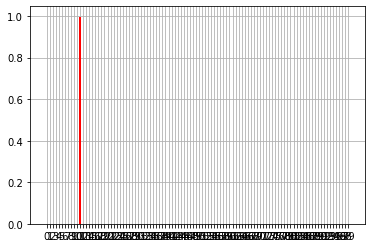

In [37]:
utils.plot_beliefs(df['prior'][9])